In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

In [4]:
# use flare table from Pineda et al. in prep.
df = pd.read_csv("data/2021_12_08_flares.csv")
df = df[df.real=="1"]
df.head()

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,ID,qcs,tstamp,dur_detrend,real
5,13523.0,13530.0,243013.0,243020.0,1564.978889,1564.988611,55.696179,3.928268,0.124217,0.009722,16035,1539914,9,01_12_2021_16_58_28,19.680489,1
6,2724.0,2738.0,230798.0,230812.0,1548.013584,1548.033029,152.094714,5.259690,0.224345,0.019445,16035,1539914,9,01_12_2021_16_58_28,19.680489,1
8,1247.0,1252.0,248546.0,248551.0,1572.663788,1572.670732,33.023852,2.285862,0.097613,0.006945,15734,2470992,10,01_12_2021_16_59_24,17.802888,1
9,10142.0,10149.0,259509.0,259516.0,1587.890238,1587.899960,91.330193,2.346427,0.286523,0.009722,15734,2470992,10,01_12_2021_16_59_24,17.802888,1
10,10455.0,10477.0,259822.0,259844.0,1588.324956,1588.355512,533.533795,4.182289,1.075059,0.030555,15734,2470992,10,01_12_2021_16_59_24,17.802888,1


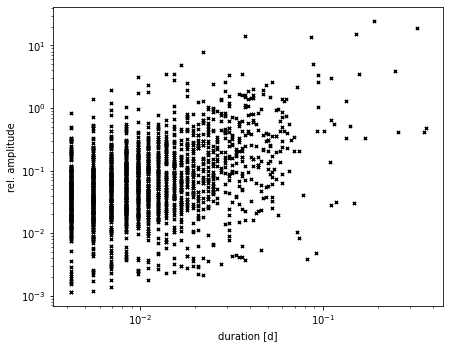

In [5]:
%matplotlib inline
plt.figure(figsize=(7,5.5))
plt.scatter(df.dur, df.ampl_rec,marker="x",s=10, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("duration [d]")
plt.ylabel("rel. amplitude");

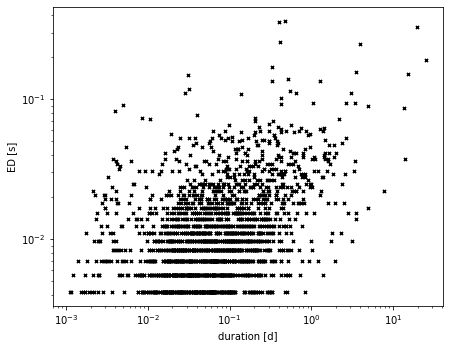

In [6]:
%matplotlib inline
plt.figure(figsize=(7,5.5))
plt.scatter(df.ampl_rec, df.dur, marker="x",s=10, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("duration [d]")
plt.ylabel("ED [s]");

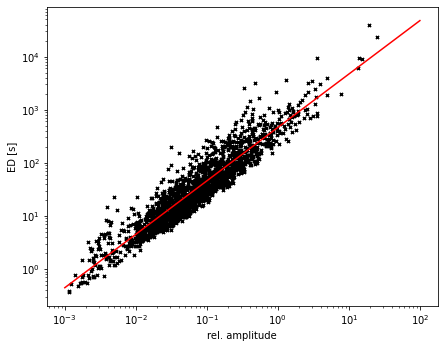

In [7]:
%matplotlib inline
plt.figure(figsize=(7,5.5))
plt.scatter(df.ampl_rec, df.ed_rec, marker="x",s=10, c="k")

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df.ampl_rec.values),
                                                               np.log10(df.ed_rec.values))
x = np.linspace(-3,2,50)
y = x * slope + intercept
plt.plot(10**x,10**y,c="r")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("rel. amplitude")
plt.ylabel("ED [s]");

1. get a from ED
2. fwhm from a and ED

In [30]:
X = 0.6890/1.600 + 0.3030/0.2783
f, g, h, i = 1.941, -0.175 ,-2.246,-1.125

def func(fwhm):
    return 1 / fwhm**4 * (X * fwhm**5 + fwhm**4 + f / 2 * fwhm**3 + g / 3 * fwhm**2 + h / 4 * fwhm + i / 5)

Text(0, 0.5, 'ED / A')

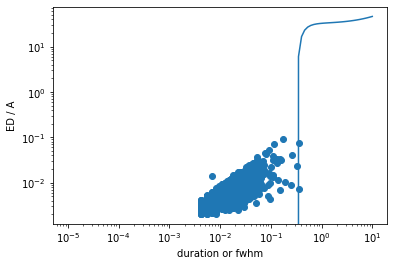

In [31]:
x = np.logspace(-5,1,100)
plt.plot(x, func(x))
plt.scatter(df.dur, df.ed_rec/60/60/24/df.ampl_rec)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("duration or fwhm")
plt.ylabel("ED / A")